Metrics for Wiki-Vote Dataset:
num_nodes: 7115
num_edges: 103689
avg_degree: 29.146591707659873
clustering_coefficient: 0.1408978458930873
degree_assortativity: -0.08324455771686787
avg_shortest_path: 2.8792828803221413

Comparison Table:
           num_nodes  num_edges  avg_degree  clustering_coefficient  \
Wiki-Vote     7115.0   103689.0   29.146592                0.140898   
BA Model      7115.0    99414.0   27.944905                0.018527   
WS Model      7115.0    14230.0    4.000000                0.367972   
SBM Model     7115.0   594732.0  167.176950                0.032185   

           degree_assortativity  avg_shortest_path  
Wiki-Vote             -0.083245           2.879283  
BA Model              -0.013799           2.820442  
WS Model              -0.007085          11.708518  
SBM Model              0.212983           2.024860  


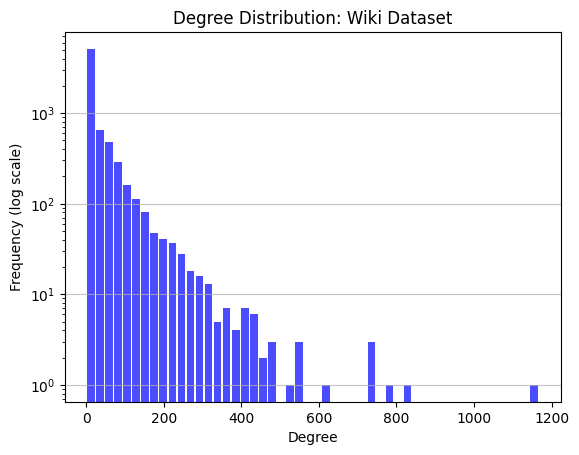

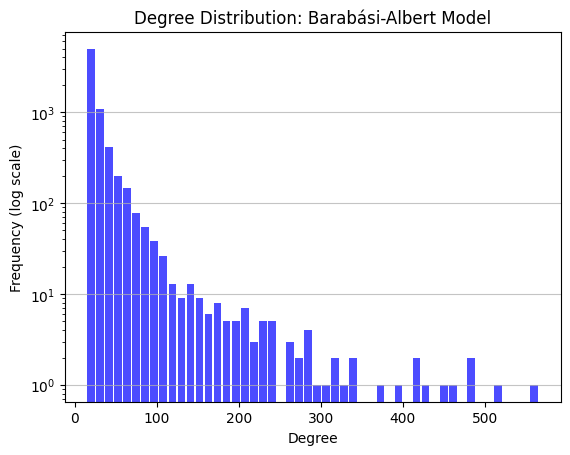

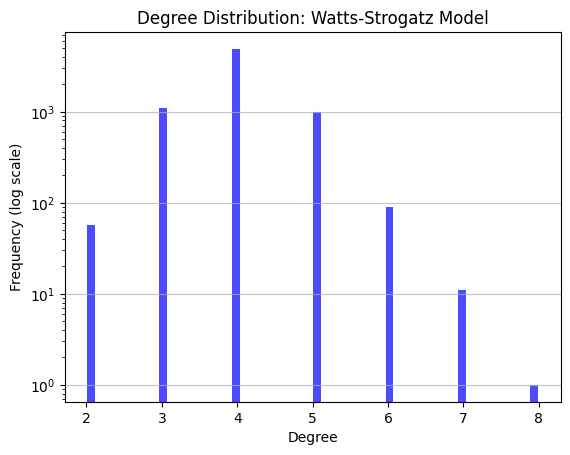

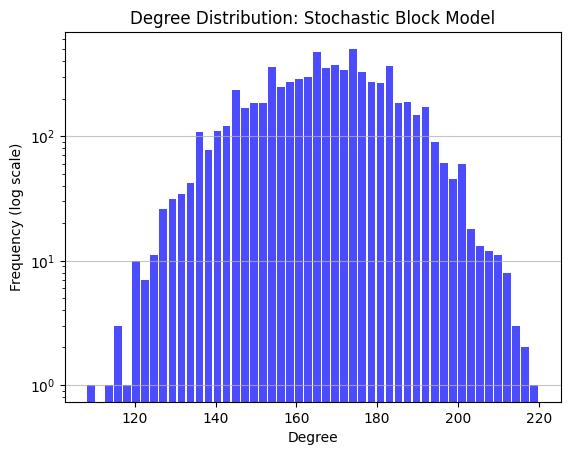

In [3]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load(file_path):
    G = nx.DiGraph()
    with open(file_path, 'r') as f:
        for line in f:
            if not line.startswith('#'):
                from_node, to_node = map(int, line.strip().split())
                G.add_edge(from_node, to_node)
    return G

WIKI = "desktop/Wiki-Vote.txt"
G_wiki = load(WIKI)

def calculate_metrics(G):
    is_directed = G.is_directed() 
    metrics = {
        "num_nodes": G.number_of_nodes(),
        "num_edges": G.number_of_edges(),
        "avg_degree": np.mean([d for n, d in G.degree()]),
        "clustering_coefficient": nx.average_clustering(G.to_undirected()),
        "degree_assortativity": nx.degree_assortativity_coefficient(G),
    }
    if is_directed:
        if nx.is_strongly_connected(G):
            metrics["avg_shortest_path"] = nx.average_shortest_path_length(G)
        else:
            largest_scc = max(nx.strongly_connected_components(G), key=len)
            G_scc = G.subgraph(largest_scc).copy()
            metrics["avg_shortest_path"] = nx.average_shortest_path_length(G_scc)
    else:
        if nx.is_connected(G):
            metrics["avg_shortest_path"] = nx.average_shortest_path_length(G)
        else:
            largest_cc = max(nx.connected_components(G), key=len)
            G_cc = G.subgraph(largest_cc).copy()
            metrics["avg_shortest_path"] = nx.average_shortest_path_length(G_cc)
    return metrics

metrics_wiki = calculate_metrics(G_wiki)
print("Metrics for Wiki-Vote Dataset:")
for key, value in metrics_wiki.items():
    print(f"{key}: {value}")

n = G_wiki.number_of_nodes()
m = G_wiki.number_of_edges() // n 
k = 4  
p = 0.1
G_BA = nx.barabasi_albert_graph(n, m)
G_WS = nx.watts_strogatz_graph(n, k, p)

sizes = [2000, 2500, 2615]
probs = [[0.05 if i == j else 0.01 for j in range(len(sizes))] for i in range(len(sizes))]
G_SBM = nx.stochastic_block_model(sizes, probs)
metrics_BA = calculate_metrics(G_BA)
metrics_WS = calculate_metrics(G_WS)
metrics_SBM = calculate_metrics(G_SBM)

comparison = pd.DataFrame({
    "Wiki-Vote": metrics_wiki,
    "BA Model": metrics_BA,
    "WS Model": metrics_WS,
    "SBM Model": metrics_SBM
})
print("\nComparison Table:")
print(comparison.T)

def plot_degree_distribution(G, title, log_scale=True):
    degrees = [d for _, d in G.degree()]
    plt.hist(degrees, bins=50, color='blue', alpha=0.7, rwidth=0.85, log=log_scale)
    plt.title(f"Degree Distribution: {title}")
    plt.xlabel("Degree")
    plt.ylabel("Frequency (log scale)" if log_scale else "Frequency")
    plt.grid(axis='y', alpha=0.75)
    plt.show()

plot_degree_distribution(G_wiki, "Wiki Dataset")
plot_degree_distribution(G_BA, "Barabási-Albert Model")
plot_degree_distribution(G_WS, "Watts-Strogatz Model")
plot_degree_distribution(G_SBM, "Stochastic Block Model")
